<a href="https://colab.research.google.com/github/tommylouistaylor/GEOG0051-DataMining/blob/main/Coursework01-Mining_Project/GEOG0051_Coursework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GEOG0051

Mining Social and Geographic Datasets
-----------------------------------

Coursework Part Two 
-------------------------------

Stephen Law and Nikki Tanu

Task: **analyse a dataset that contains review data of different venues** in Calgary, Canada. 

With the help of several **ML techniques** that we have learnt in the course, you will be tasked to **distill insights from this social media dataset**.  

Two of the dataset's notable features are:
*   The **geocoding of every reviewed venues** 
*   the availability of a **considerable amount of text data**
Both lends the ability to be **processed using spatial and text analysis techniques** respectively. 

As a prelude to the analysis prompts below, think about... 
*   What can we discover about the venue review data?
*   What spatial patterns can be extracted from the data?
*   Can we build a ML model that predicts review rating for unseen data points using the text of the reviews??
*   Are there certain tendencies in the sentiment of the reviews based on certain factors?
 

The variables contained in the dataset provided in a .csv file, are:

* `business_id`, unique identifier of the premise
* `Name`, name of premise
* `latitude`, `longitude`, i.e. the locational attributes of the venue. <br/>
* `reviewcount` or the number of reviews the venue has been given<br/>
* `categories` general category of establishment that a venue falls under 
(Note: this variable is rather messy and might needs some cleaning/consolidation to be usable)<br/>
* `hours` or the opening hours of the venue <br/>
* `reviewid` unique identifier of the review <br/>
* `userid` unique identifier of the individual who left the review<br/>
* `starsy` individual ratings of the venue<br/>
* `useful`, `funny`, `cool`, `text`, i.e. tags that the user attached to the review<br/>
* `date` i.e. the date of the review<br/>

### 3.2.1 Loading and cleaning the dataset

In a realistic context, most text datasets are messy in their raw forms.  They **require considerable data cleaning** before any analysis can be conducted and, not unlike data cleaning for non-textual datasets, this would **include the removal of invalid data, missing values, and outliers**.

TASK: prepare the dataset for subsequent analysis.
*  Load and understand the dataset.
*  Think about which attributes you will use / focus on (in subsequent prompts) and check its data distribution.
*  Pre-process the text review data and create a new column in the data frame which will hold the cleaned review data.
*  Some of the steps to consider are: removal of numbers, punctuation, short words, stopwords, lemmatise words, etc. 
```

#### Setup the notebook

In [2]:
# MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# INSTALL MODULES
!pip install geopandas
!pip install scikit-surprise
!pip install vaderSentiment

In [4]:
# IMPORT MODULES

# Standard
from google.colab import files                              # uploading files directly into notebook
from IPython.core.interactiveshell import InteractiveShell  # for displaying multiple outputs at once
import os

# Numeric
import numpy as np
import pandas as pd
import geopandas as gpd
import re

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#### Load and Understand the Data

In [5]:
# LOAD CSV INTO DF:
def read_csv(dataset):
  df = pd.read_csv(dataset)
  # df.info() # identify cols & datatypes
  df['date'] = pd.to_datetime(df['date'],  dayfirst=True) # convert to datetime format
  df = df.astype({"stars_y": 'int64'}) # convert to int
  list_headers = list(df.columns.values)
  return df, list_headers

csv = '/content/drive/My Drive/Colab Notebooks/GEOG0051-DataMining/Coursework01-Mining_Project/df_Calgary_pre.csv'
df, list_headers = read_csv(csv)
row_count = len(df.index)

# df.head()

In [ ]:
# provide initial orientation of the data

# counts of businesses at each rating
df['stars_y'] = df['stars_y'].astype('float')
df['stars_y'].value_counts().plot(kind='bar',color='black')

# number of unique users and items
print ("There are " + str(len(df['user_id'].unique())) + " unique users_ids in the dataset.")
print ("There are " + str(len(df['business_id'].unique())) + " unique business_ids in the dataset.")

# top five users in terms of rating counts
ascending_list = df.groupby('user_id')['stars_y'].count().reset_index().sort_values('stars_y',ascending=False)
display(ascending_list.head())

# create a user-item matrix identify NaN vals which have to be predicted
user_item_matrix = df.reset_index().pivot_table(values='stars_y', index='user_id', columns='business_id', aggfunc='mean')
user_item_matrix.head()

#### Pre-process the text review data

In [ ]:
# ROW CLEANING

# remove duplicate reviews (rows)
def remove_duplicates(df):
  df.drop_duplicates(keep=False, inplace=True)
  return df

row_count = len(df.index)
# df.head()

# remove rows where 'text' is fewer than 5 words using string manipulation
def filter_by_length(df):
  df['text_length'] = df['text'].str.len()  # populate new col with length
  df = df[df['text_length']>5] # apply filter
  df = df.drop(columns=['text_length'])
  return df

df = filter_by_length(df)

# numbers removed
rows_after_process = len(df.index)
count_diff = int(row_count)-int(rows_after_process)
print("Row filtering removed {} rows".format(count_diff))
row_count = len(df.index)
# df.head()

In [9]:
# removes all numbers using regex library
def remove_numbers(text):
  text = re.sub(r'[0-9]', '', text)
  return text

df['name'] = df.apply(lambda row : remove_numbers(row['name']), axis = 1)
df['categories'] = df.apply(lambda row : remove_numbers(row['categories']), axis = 1)
df['text'] = df.apply(lambda row : remove_numbers(row['text']), axis = 1)

# df.head()

In [10]:
# tokenise everything between commas using Regex

def split_between_comma(text):
  text = re.split(r'[.,]', text)
  return text

df['categories'] = df.apply(lambda row : split_between_comma(row['categories']), axis = 1)

# df.head()


In [11]:
# removes all punctuations using regex library
def remove_punctuation(text):
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('_', ' ', text)
  return text

df['business_id'] = df.apply(lambda row : remove_punctuation(row['business_id']), axis = 1)
df['name'] = df.apply(lambda row : remove_punctuation(row['name']), axis = 1)
df['review_id'] = df.apply(lambda row : remove_punctuation(row['review_id']), axis = 1)
df['user_id'] = df.apply(lambda row : remove_punctuation(row['user_id']), axis = 1)
df['text'] = df.apply(lambda row : remove_punctuation(row['text']), axis = 1)

# df.head()

In [12]:
# remove all short words (≤3) using regex library
def remove_short_words(text):
  text = re.sub(r'\b\w{1,3}\b', '', text)
  return text

df['text'] = df.apply(lambda row : remove_short_words(row['text']), axis = 1)

# df.head()

In [13]:
# remove whitespaces (where necessary)
def remove_spaces(text):
  text = " ".join(text.split())
  return text

df['text'] = df.apply(lambda row : remove_short_words(row['text']), axis = 1)

In [14]:
# remove multiple whitespaces (where necessary)
def remove_spaces(text):
  text = text.replace(" ", "")
  return text

df['business_id'] = df.apply(lambda row : remove_spaces(row['business_id']), axis = 1)
df['review_id'] = df.apply(lambda row : remove_spaces(row['review_id']), axis = 1)
df['user_id'] = df.apply(lambda row : remove_spaces(row['user_id']), axis = 1)

# df.head()

In [ ]:
# assign new ids
df['business_id_new'] = df.groupby(['business_id']).ngroup().astype(int)
replace_zero = int(df['business_id_new'].nunique() + 1)
df["business_id_new"].replace({0: replace_zero}, inplace=True)

df['review_id_new'] = df.groupby(['review_id']).ngroup().astype(int)
replace_zero = int(df['review_id_new'].nunique() + 1)
df["review_id_new"].replace({0: replace_zero}, inplace=True)

df['user_id_new'] = df.groupby(['user_id']).ngroup().astype(int)
replace_zero = int(df['user_id_new'].nunique() + 1)
df["user_id_new"].replace({0: replace_zero}, inplace=True)

df = df.sort_values(['business_id_new'], ascending=True)
# df.drop(['business_id', 'review_id', 'user_id'], axis = 1)

display(df.head(50))

In [ ]:
# tokenize words using nltk library aka 'chopping up into pieces'
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string

def split_into_words(text):
  word_tokens = word_tokenize(text)
  word_tokens = [ x for x in word_tokens if x != []]  # remove empty lists
  return word_tokens

df['text'] = df.apply(lambda row : split_into_words(row['text']), axis = 1)

# df.head()

In [17]:
# normalizing casing
def normalise_casing(text):
  text = text.replace(text, text.lower())
  return text

df['name'] = df.apply(lambda row : normalise_casing(row['name']), axis = 1)

def normalise_casing_tokens(tokens):
  tokens = [w.lower() for w in tokens]
  return tokens

df['text'] = df.apply(lambda row : normalise_casing_tokens(row['text']), axis = 1)
df['categories'] = df.apply(lambda row : normalise_casing_tokens(row['categories']), axis = 1)

# df.head()

In [ ]:
# filter out stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
def remove_stopwords(tokens):
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  return tokens

df['text'] = df.apply(lambda row : remove_stopwords(row['text']), axis = 1)

# df.head()

In [ ]:
# lemmentization
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
 
def lemmentize_words(tokens):
  wnl = WordNetLemmatizer() #Create WordNetLemmatizer object
  lematized = []      
  for word in tokens:
    lematized.append(wnl.lemmatize(word))
  return lematized

df['text'] = df.apply(lambda row : lemmentize_words(row['text']), axis = 1)

# df.head()

In [20]:
# stemming words
from nltk.stem.porter import PorterStemmer

def stem_words(words):
  porter = PorterStemmer()  # using Porter Stemming algorithm
  stemmed = [porter.stem(word) for word in words]
  return stemmed

df['text'] = df.apply(lambda row : stem_words(row['text']), axis = 1)

# df.head()

In [ ]:
df.head()

### 3.2.2 Build a supervised learning model for text analysis
The objective of this sub-task is to build a supervised learning model that predicts the star ratings of the venue data, based on the different features of each review included in the dataset. You can choose a subset of venues to review for example based on a general category. You can use a combination of text and non-text features, and below are some guidelines that you could follow:

*  Firstly, vectorise the preprocessed review text data to give text features you can used in your model.

* Split your dataset into a train and test-set and train K$\geq$2 machine learning models to predict the star rating varying either features used (E.g. bag of words features vs TF-IDF features) or choice of models.

*  Report the model test results.

*  Discuss and interpret the results you obtained.

#### Firstly, vectorise the preprocessed review text data to give text features you can used in your model.

In [ ]:
# vectorise the preprocessed review text --- transforms series of strings into a vector, detailing token counts.

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def vectorise_documents(corpus):

  # initialise vectoriser and perform secondary preprocessing/tokenisation
  vectorizer = CountVectorizer(analyzer='word') 
                              #  min_df=1, stop_words='english')

  # tokenise and count word occurrences 
  X = vectorizer.fit_transform(corpus)

  # assign a unique integer index corresponding to a column in the resulting matrix
  vectorizer.get_feature_names() # output feature names
  X.toarray() # array of indexes

  # map feature name to column index
  vector = vectorizer.vocabulary_ # see keys for the vectoriser
  return vector


# df['business_id'] = df.apply(lambda row : vectorise_documents(row['business_id']), axis = 1)
# df['name'] = df.apply(lambda row : vectorise_documents(row['name']), axis = 1)
df['categories'] = df.apply(lambda row : vectorise_documents(row['categories']), axis = 1)
# df['review_id'] = df.apply(lambda row : vectorise_documents(row['review_id']), axis = 1)
# df['user_id'] = df.apply(lambda row : vectorise_documents(row['user_id']), axis = 1)
df['text'] = df.apply(lambda row : vectorise_documents(row['text']), axis = 1)

df.head()


#### Split your dataset into a train and test-set and train K≥2 machine learning models to predict the star rating varying either features used (E.g. bag of words features vs TF-IDF features) or choice of models.

In [ ]:
# save preprocessed df to csv in ipython before crashes again
df.to_csv('preprocessed_df.csv', index=False, encoding='utf-8-sig')

import pandas as pd

# MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount("/content/drive")

%cd drive/MyDrive/Colab Notebooks

dataset = 'preprocessed_df.csv'
df = pd.read_csv(dataset)
# df.head()

#### Recommender Model

In [ ]:
# split dataset into train and test
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import Dataset

# select subset
df2 = df[['user_id_new', 'business_id_new', 'stars_y']]
df2.drop_duplicates(keep=False, inplace=True)

# Scikit Reader to load in data
reader=Reader(rating_scale=(1, 5))
df2_dataset = Dataset.load_from_df(df2, reader)  # output is <surprise.dataset.DatasetAutoFolds object at 0x7f4ddf1aeb50>
# print(df2_dataset)

# resample data randomly into a train and test set
train_data, test_data = train_test_split(df2_dataset, test_size=0.25, random_state=1)
# print(type(test_data))
# print(type(train_data))

In [ ]:
# RECOMMENDER SYSTEM 1
from surprise import accuracy
from surprise import SVD
from surprise import KNNBasic
from surprise.model_selection import cross_validate

# train an SVD matrix factorisation model
algo = SVD()
algo.fit(train_data)
predictions = algo.test(test_data)
print(f'{accuracy.rmse(predictions)}')

# evaluate the recommender models
cross_validate(algo, df2_dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# RECOMMENDER SYSTEM 2
from surprise import KNNBasic

# train an KNNBasic model
algo2 = KNNBasic(k=40)
algo2.fit(train_data)
predictions = algo2.test(test_data)
print(f'{accuracy.rmse(predictions)}')

# evaluate the recommender models
cross_validate(algo, df2_dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# predict business reviews (SVD)
userid=2
businesslist=np.arange(1,len(df['item_id'].unique()),1)
user2_pred=[]
for i in businesslist:
    businessid=i
    name=dfbusiness[dfbusiness['businessid']==businessid]['businesstitle'].values[0]
    pred=algo.predict(uid=userid,iid=businessid)
    print (f'user {userid} predicted rating for {name}: {pred.est}')
    user2_pred.append(pred.est)
print (f'average predicted rating for user=2: {np.mean(user2_pred)}')

#### Supervised Text Classification Model
train a machine learning model that is able to classify texts into categories based on the relative occurrence of tokens within them

In [25]:
# # this gets the training set and vectorise it
# x_train, x_test, y_train, y_test = train_test_split(dataset.data, dataset.target, 
#                                                       test_size = 0.20, random_state = 1)
# x_train_vectors = tf_vectorizer.transform(x_train)
# x_test_vectors = tf_vectorizer.transform(x_test)

In [ ]:
# # this fit the Naive Bayes Classifier
# clf = MultinomialNB()
# clf.fit(x_train_vectors, y_train)

# # this uses the Naive Bayes Classifier to predict
# y_pred = clf.predict(x_test_vectors)

# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('txt_sentoken/pos', vocab)
process_docs('txt_sentoken/neg', vocab)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

In [ ]:
# # check accuracy of the model

# # this prints the f1_score 
# print (f1_score(y_test, y_pred, average='macro'))
# print (accuracy_score(y_test, y_pred))

# #create confusion matrix
# f, ax = plt.subplots(figsize=(7, 5))
# sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")

In [ ]:
# # make predictions on unseen data

# #creates two dummy strings for the model to predict on
# docs_new = ['I believe in a religion', 'my computer is fast']
# X_new_counts = tf_vectorizer.transform(docs_new)

# predictions=clf.predict(X_new_counts)

# #prints the predictions of the model
# for i in predictions:
#     print (pd.DataFrame(dataset.target_names,columns=['class']).loc[i].values[0])

#### Topic Modelling

Predict the probabilities that a given document is mainly speaking about a certain topic that it discovered, then allocates a document into topic groups based on their highest topic probability.

### 3.2.3. Geographic visualisation with geopandas and folium

Having explored the dataset, its constituent variables and coverage above, the objective of this sub-task is for you to visualise any of the spatial patterns that emerge from the data that you find interesting. This task is intentionally open-ended and leaves you with some choice. To achieve this, you should:

* Choose 1 or 2 variables (including any variables you generated from 3.2.2) that you wish to explore and from the list ofvariables available in the dataset

* Use either or both of the geopandas and folium libraries in Python to produce up to 3 visualisations

* Comment on the spatial distributions of the 1-2 variables you chose, any trends or outliers that emerge and if they haveany notable implications.

* **Note**: You may use any subset of the dataset instead of the entire dataset, but comment on why you chose this subset.


In [ ]:
# CONVERT DF INTO gdf:
def df_to_gdf(df):
  gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)) # creates df with geometry series
  gdf = gdf.set_crs(epsg=4326)                                       # set g-crs to WGS84 for rendering in Folium
  # df_proj = df_geog.to_crs(epsg=3857)                                   # set p-crs to Web Mercator for rendering with Contextily basemaps
  return gdf
  
gdf = df_to_gdf(df)
df.info()

In [ ]:
# load calgary shapefile as df
from google.colab import files
calgary_shapefile = files.upload()
df=gpd.read_file(calgary_shapefile)

### 3.2.4 Extra task (Optional)

For extra marks, you could choose 1 of EITHER:

(a) Use a pretrained neural word embedding method (ie. `word2vec`) for the supervised learning task and compare the results with the bag of words features, OR,

(b) Apply topic modelling (eg. `LDA`) on the text data and give a characterisation of each of the topics that your topic model generates. Comment briefly on whether these characterisations were roughly what you expected before, OR,

(c) Run a lexicon-based sentiment analysis (eg. `NLTK Vader Sentiment Analyser`) on the textual data, then report and discuss the results. Does the average lexicon sentiment score for each venue correlate with the average venue ratings provided by the users?

In [ ]:
# (C) RUN LEXICON-BASED SENTIMENT ANALYSIS
# determine whether textual data in 'text' col is positive, negative or neutral.

import nltk
nltk.download('vader_lexicon')

def sentiment_from_text(df):
  # get pre-trained tokenizer
  import nltk.data
  nltk.download('punkt')                     # add punkt english tokenizer
  from nltk import sent_tokenize, word_tokenize, pos_tag

  # get english stopwords
  from nltk.corpus import stopwords          # for getting lists of stopwords
  nltk.download('stopwords')                 # add stopword downloder
  all_stopwords = stopwords.words('english') # get english stopwords

  # get sentiment intensity scorer
  from nltk.sentiment.vader import SentimentIntensityAnalyzer 
  sid = SentimentIntensityAnalyzer()

  # run sentiment analysis on dataset
  df['text_sentiment']=np.NaN               # create new col to store sentiment vals
  for review in df.iterrows():              # for every text review in df
    sent=review[1]['text']
    sent=nltk.word_tokenize(sent)            # tokenize words 
    sent=[i for i in sent if not i in all_stopwords] # preprocess text (ie. remove stopwords)
    sent=' '.join(sent)                      # join words back to review sentence
    ps=sid.polarity_scores(sent)             # gives sentiment intensity score to sentences
    df.loc[review[0],['text_sentiment']]=ps['compound'] # store sentiment ['compound'] in text_sentiment col
  return df

df = sentiment_from_text(df)
df.head(20)

In [29]:
# calculate mean sentiment score per business
def calc_mean_sent(df):
  df_sentiment = pd.DataFrame(df.groupby(['name'])['text_sentiment'].mean())
  df_lon=pd.DataFrame(df.groupby(['name'])['longitude'].mean())
  df_lat=pd.DataFrame(df.groupby(['name'])['latitude'].mean())
  df_avg_score=pd.DataFrame(df.groupby(['name'])['stars_y'].mean())
  df_rev_vs_sent = pd.concat([df_sentiment, df_avg_score], axis=1) # concatenate review and sentiment scores
  df_rev_vs_sent.head(20)
  return df_rev_vs_sent

df_rev_vs_sent = calc_mean_sent(df)

<Figure size 1080x1080 with 0 Axes>

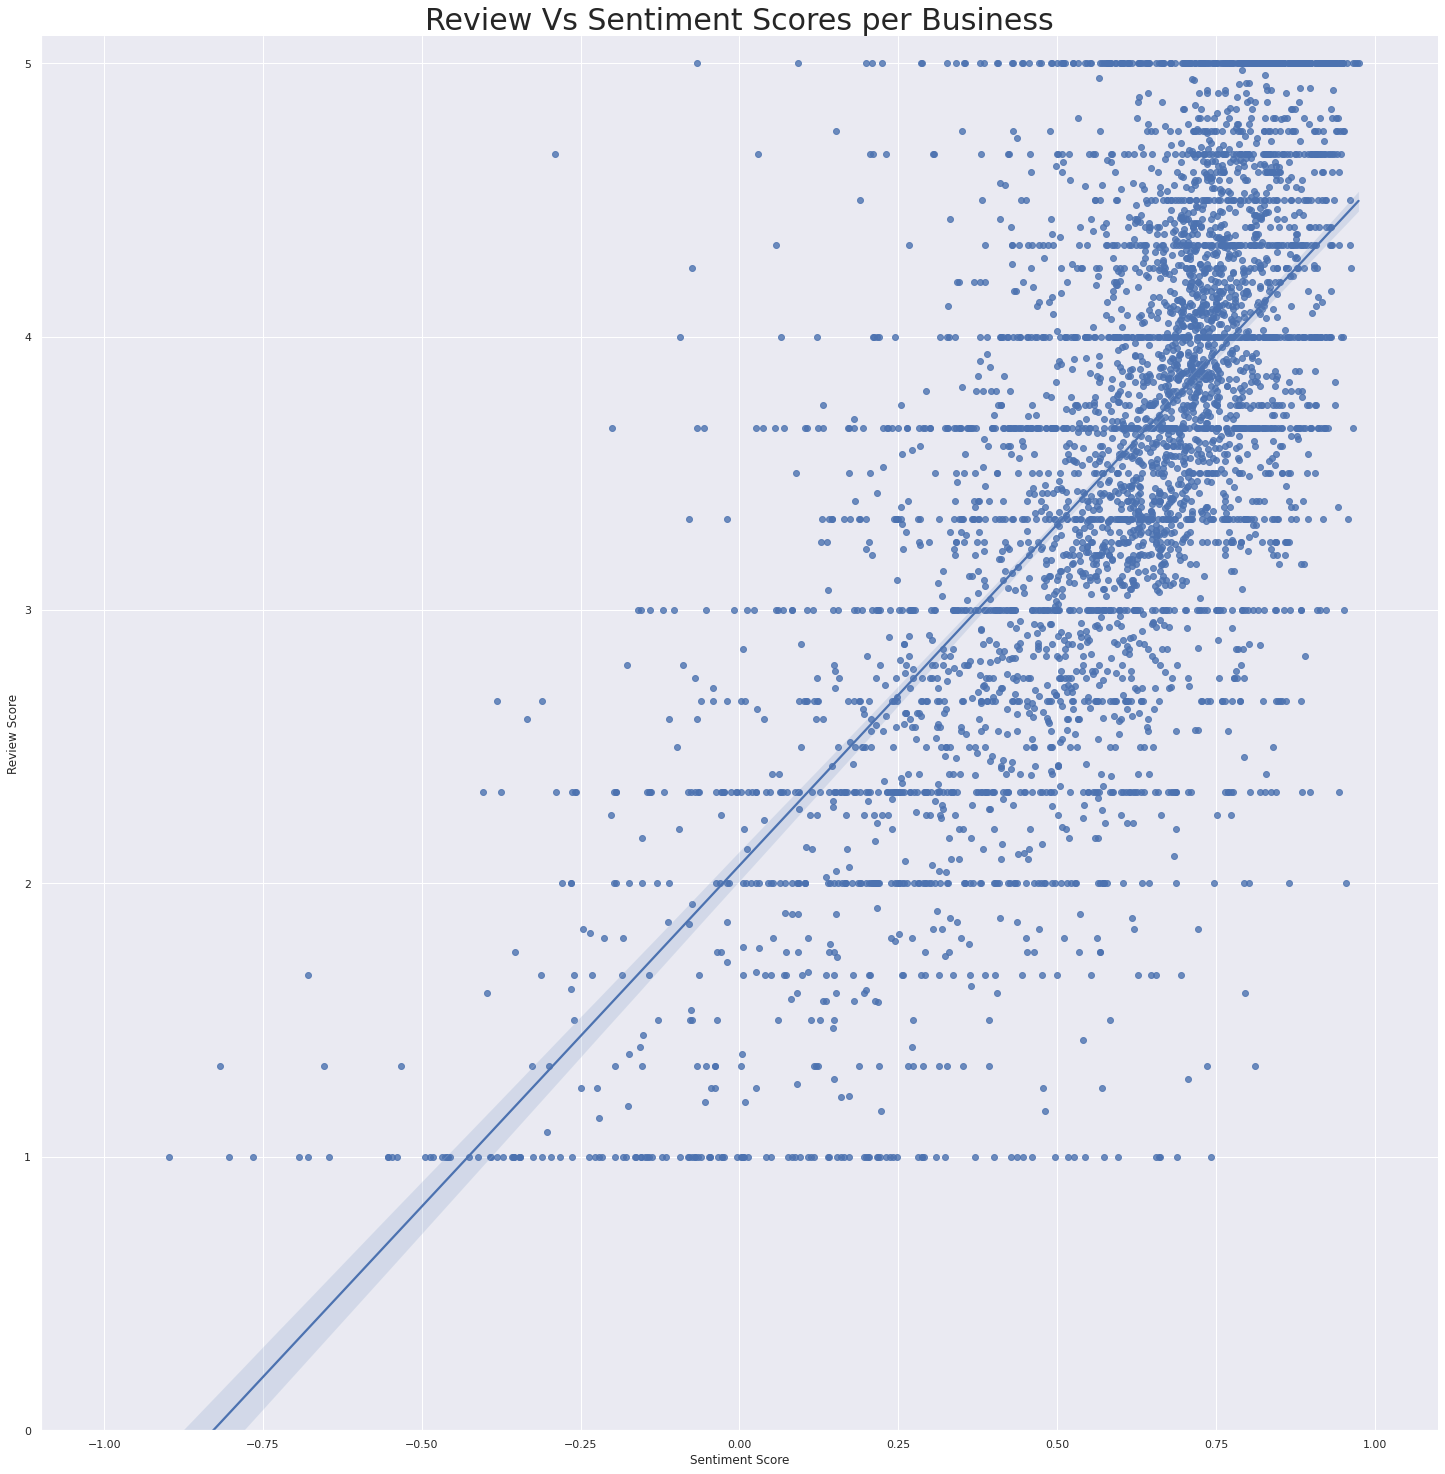

In [30]:
# review vs sentiment graph
def review_vs_sentiment(df):
  figure = plt.figure(figsize=(15,15)) # create figure
  import seaborn as sns
  sns.set_theme(color_codes=True)
  ax = sns.lmplot(x="text_sentiment", y="stars_y", data=df, sharex=False, sharey=False, palette="Set1", height=20, legend='auto', fit_reg=True)
  ax.set(xlim=(-1.1, 1.1))
  ax.set(ylim=(0, 5.1))
  ax.set(xlabel='Sentiment Score', ylabel='Review Score')
  plt.title("Review Vs Sentiment Scores per Business", fontsize=30)
  plt.show()

review_vs_sentiment(df_rev_vs_sent)